In [1]:
# Imports
import json
import torch
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [2]:
# Load files
def load_probs(path):
    with open(path, "r") as _file:
        probs = json.load(_file)
    return probs

weak_median_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/data/weak_models/medians/undertrain-mnli-epoch-comparison-"
debias_median_path = "???"
weak_medians = [load_probs(weak_median_path + str(i) + ".json") for i in range(1, 6)]
# debias_medians = [load_probs(debias_median_path + str(i) + ".json") for i in range(???)]

In [3]:
weak_median_array = np.array([list(element.values()) for element in weak_medians])
# debias_median_array = np.array([list(element.values()) for element in debias_medians])

In [5]:
weak_median_array.shape

(5, 392702, 3)

In [54]:
# Short + High Precision Run

# base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/800_it_train_20_step/runs/2022-04-25/14-55-07/"
# batch_size = 32
# recording_rate = 20

In [69]:
# Longer and Lower Precision Run

base_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/"
batch_size = 32
recording_rate = 200

In [70]:
import glob
train_files = glob.glob(base_path + "train_predictions/*.npy")
val_files = glob.glob(base_path + "val_predictions/*.npy")
num_recordings = len(train_files)

# Sanity check: order of files must be the "natural order"
train_files, val_files

(['/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/0.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/1.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/2.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/3.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/4.npy',
  '/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/record_preds/50_percent_train_200_step/multiruns/2022-04-24/18-55-00/0/train_predictions/5.npy',
  '/remote/csifs1/disk0/meissner/shortcut-prun

In [71]:
train_preds = [np.load(_file) for _file in train_files]
val_preds = [np.load(_file) for _file in val_files]

In [72]:
steps = [i * batch_size * recording_rate for i in range(num_recordings)]

In [73]:
train_cont_levels = [preds[train_conts, 2].mean() for preds in train_preds]
train_ent_levels = [preds[train_ents, 0].mean() for preds in train_preds]
val_cont_levels = [preds[val_conts, 2].mean() for preds in val_preds]
val_ent_levels = [preds[val_ents, 0].mean() for preds in val_preds]

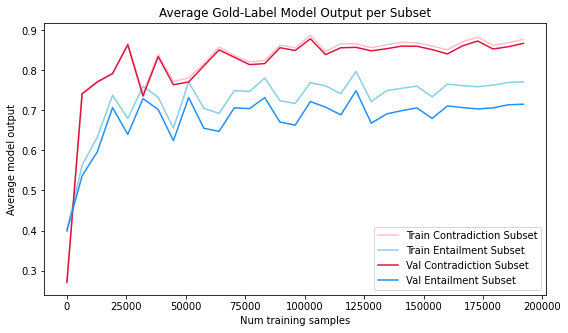

In [74]:
plt.plot(steps, train_cont_levels, label="Train Contradiction Subset", color="pink")
plt.plot(steps, train_ent_levels, label="Train Entailment Subset", color="skyblue")
plt.plot(steps, val_cont_levels, label="Val Contradiction Subset", color="crimson")
plt.plot(steps, val_ent_levels, label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num training samples")
plt.ylabel("Average model output")
plt.title("Average Gold-Label Model Output per Subset")
plt.legend()

In [75]:
train_dfs = [pd.DataFrame(array) for array in train_preds]
val_dfs = [pd.DataFrame(array) for array in val_preds]

In [76]:
for df in train_dfs:
    df.loc[train_conts, "label"] = "contradiction"
    df.loc[train_conts, "gold_pred"] = df[2]
    df.loc[train_ents, "label"] = "entailment"
    df.loc[train_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)
    
for df in val_dfs:
    df.loc[val_conts, "label"] = "contradiction"
    df.loc[val_conts, "gold_pred"] = df[2]
    df.loc[val_ents, "label"] = "entailment"
    df.loc[val_ents, "gold_pred"] = df[0]
    df.drop([0, 1, 2], axis=1, inplace=True)
    df.dropna(inplace=True)

In [77]:
percent = 0.1
negation_train_count = len(train_conts) + len(train_ents)
negation_val_count = len(val_conts) + len(val_ents)
negation_train_count, negation_val_count

(72437, 1805)

In [78]:
train_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_train_count)).groupby("label").count() for df in train_dfs]
val_worst = [df.sort_values("gold_pred", ascending=True).head(int(percent * negation_val_count)).groupby("label").count() for df in val_dfs]

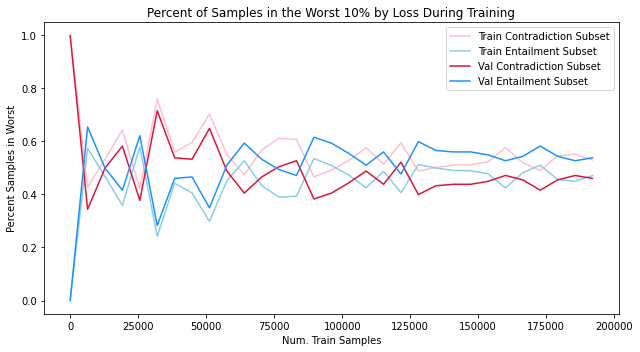

In [79]:
plt.rcParams["figure.figsize"] = (9,5)
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_train_count) if 'contradiction' in series.index else 0 for series in train_worst], label="Train Contradiction Subset", color="pink")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_train_count) if 'entailment' in series.index else 0 for series in train_worst], label="Train Entailment Subset", color="skyblue")
plt.plot(steps, [series.loc['contradiction'] / (percent * negation_val_count) if 'contradiction' in series.index else 0 for series in val_worst], label="Val Contradiction Subset", color="crimson")
plt.plot(steps, [series.loc['entailment'] / (percent * negation_val_count) if 'entailment' in series.index else 0 for series in val_worst], label="Val Entailment Subset", color="dodgerblue")
plt.xlabel("Num. Train Samples")
plt.ylabel("Percent Samples in Worst")
plt.title("Percent of Samples in the Worst 10% by Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()